Читаем библиотеки

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация

In [3]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(  num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2022-10-22 13:53:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2022-10-22 13:53:19 (96.3 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [7]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [8]:
token_list

[]

In [9]:
tokenizer.index_word[14]

'love'

In [10]:
tokenizer.word_index['love']

14

In [11]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]],
      dtype=int32)

In [12]:
label.shape

(15462, 3211)

Создаем сеть

In [13]:
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

In [14]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128 ))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 256)           822016    
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1605)              207045    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                                 
Total params: 6,383,047
Trainable params: 6,383,047
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 11s 10ms/step - loss: 6.9855 - accuracy: 0.0229 - val_loss: 6.7530 - val_accuracy: 0.0162
Epoch 2/100
387/387 [==============================] - 3s 7ms/step - loss: 6.4804 - accuracy: 0.0231 - val_loss: 6.8968 - val_accuracy: 0.0162
Epoch 3/100
387/387 [==============================] - 3s 7ms/step - loss: 6.3683 - accuracy: 0.0264 - val_loss: 7.0086 - val_accuracy: 0.0236
Epoch 4/100
387/387 [==============================] - 3s 7ms/step - loss: 6.2469 - accuracy: 0.0349 - val_loss: 7.1248 - val_accuracy: 0.0236
Epoch 5/100
387/387 [==============================] - 3s 7ms/step - loss: 6.1148 - accuracy: 0.0386 - val_loss: 7.1562 - val_accuracy: 0.0239
Epoch 6/100
387/387 [==============================] - 3s 7ms/step - loss: 5.9914 - accuracy: 0.0428 - val_loss: 7.3111 - val_accuracy: 0.0304
Epoch 7/100
387/387 [==============================] - 3s 7ms/step - loss: 5.8704 - accuracy: 0.0462 - val_loss: 7.4845 - val_accuracy: 0.03

Тест


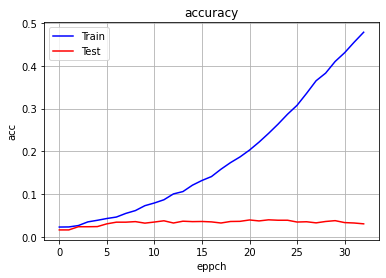

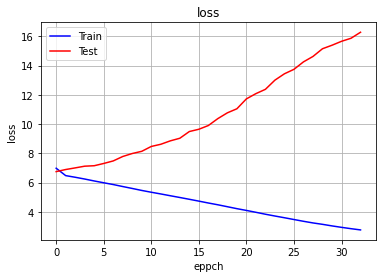

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

Строим тест генератора

In [18]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "machine learning is true"
next_words = 10
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
  predicted = model.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
1
[591, 18, 5, 352, 393, 1]
111
[591, 18, 5, 352, 393, 1, 111]
3
[591, 18, 5, 352, 393, 1, 111, 3]
111
[591, 18, 5, 352, 393, 1, 111, 3, 111]
148
[591, 18, 5, 352, 393, 1, 111, 3, 111, 148]
135
[591, 18, 5, 352, 393, 1, 111, 3, 111, 148, 135]
638
[591, 18, 5, 352, 393, 1, 111, 3, 111, 148, 135, 638]
149
[591, 18, 5, 352, 393, 1, 111, 3, 111, 148, 135, 638, 149]
32
[591, 18, 5, 352, 393, 1, 111, 3, 111, 148, 135, 638, 149, 32]
323
Help me Obi Wan Kenobi, you're my only hope and life to life up too grave sight doth sing


Помоги мне, Оби-Ван Кеноби, ты моя единственная надежда, все твои старые глаза, новые истинные глаза, сказал один

In [19]:
y_p=model.predict(token_list)

1/1 [==============================] - 0s 18ms/step


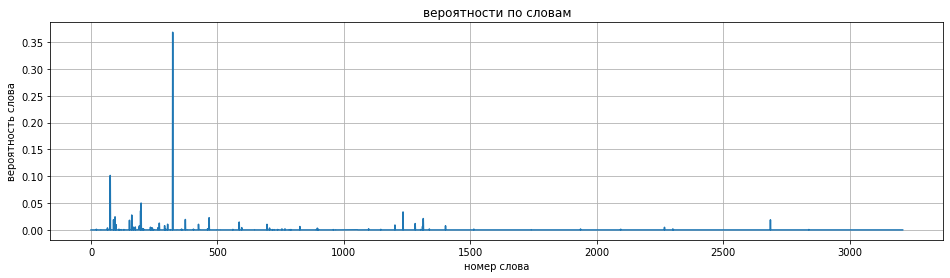

In [20]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [21]:
ind_prob=np.where(y_p[0,:]>0.06)[0]
ind_prob

array([ 76, 323])

In [22]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

see  :  0.10157173
sing  :  0.3685486


In [23]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p = model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
1/1 [==============================] - 0s 15ms/step
[591, 18, 5, 352, 393, 36]
1/1 [==============================] - 0s 17ms/step
[591, 18, 5, 352, 393, 36, 19]
1/1 [==============================] - 0s 17ms/step
[591, 18, 5, 352, 393, 36, 19, 1]
1/1 [==============================] - 0s 14ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62]
1/1 [==============================] - 0s 21ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147]
1/1 [==============================] - 0s 18ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147, 2038]
1/1 [==============================] - 0s 18ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147, 2038, 1224]
1/1 [==============================] - 0s 23ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147, 2038, 1224, 1877]
1/1 [==============================] - 0s 18ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147, 2038, 1224, 1877, 848]
1/1 [==============================] - 0s 20ms/step
[591, 18, 5, 352, 393, 36, 19, 1, 62, 147, 2038, 1224

Help me Obi Wan Kenobi, you're my only hope by ill pen ' ' be gone into my sight and end truth quite unrespected

Помоги мне, Оби-Ван Кеноби, ты моя единственная надежда из-за плохого пера исчезнуть в моих глазах и покончить с правдой совершенно неуважительно
